# Introduction to Dynamic Programming

Solves and simulates a simple $T$-period consumption-saving model:

$$
\begin{align}
V_t(\color{blue}{a_t}) & = \max_{\color{red}{c_t}>0} \frac{\color{red}{c_t}^{1-\rho}}{1-\rho} +\beta \cdot V_{t+1}(\color{green}{a_{t+1}})\\
& \text{s.t.} \\
\color{green}{a_{t+1}} & = (1+r)(\color{blue}{a_t} - \color{red}{c_t} + y_t), \, a_0=0\\
a_t & \geq 0, \forall \, t \text{(not allowed to borrow)}
\end{align}
$$
where 
- $V_t(a_t)$ is the value function, associated with starting a period with $a_t$ wealth. 
- $y_t=y$ is a known per-period level of income (constant income).
- $\rho>0$ is the CRRA coefficient
- $\beta\in(0,1)$ is the discount factor
- $r$ is the real interest rate
- $a_t$ is a state variable

**Objective**: We are interested in solving for 
- the value functions, $V_t(a_t)$ for all $t=0,\dots,T-1$ and all potential levels of $a_t$.  We assume no value of bequest, such that $V_T(a_T)=0$. 
- the consumption (policy) functions, $c_t^{\star}(a_t)$ for all $t=0,\dots,T-1$ and all potential levels of $a_t$, is given by 
$$
c_t^{\star}(\color{blue}{a_t}) = \arg\max_{0<\color{red}{c_t}\leq\color{blue}{a_t} + y_t} \underset{v_t(\color{red}{c_t}|\color{blue}{a_t})}{\underbrace{\frac{\color{red}{c_t}^{1-\rho}}{1-\rho} +\beta \cdot V_{t+1}((1+r)(\color{blue}{a_t} - \color{red}{c_t} + y_t))}} \\
$$ where $v_t(\color{red}{c_t}|\color{blue}{a_t})$ is the "value of choice" $c_t$.

**Approach**: *Backwards induction*.
1. Start from the terminal/last period, $T-1$ (since we index first period with $t=0$). <br> We assumed no continuation value ($V_{T}(a_T)=0$), and it is thus optimal to consume all resources;
$$
\begin{align}
c^{\star}_{T-1}(a_{T-1}) &= a_{T-1}+y_{T-1}\\
V_{T-1}(a_{T-1}) &= \frac{(a_{T-1}+y_{T-1})^{1-\rho}}{1-\rho}.
\end{align}
$$ We can calculate these on a *grid* of values $\overrightarrow{a}$.
2. Solve $T-2$-period: 
$$
c_{T-2}^{\star}(\color{blue}{a_{T-2}}) = \arg\max_{0<\color{red}{c_{T-2}}\leq\color{blue}{a_{T-2}} + y_{T-2}} \underset{v_{T-2}(\color{red}{c_{T-2}}|\color{blue}{a_{T-2}})}{\underbrace{\frac{\color{red}{c_{T-2}}^{1-\rho}}{1-\rho} +\beta \cdot V_{T-1}((1+r)(\color{blue}{a_{T-2}} - \color{red}{c_{T-2}} + y_{T-2}))}} \\
$$ where we must *interpolate* the continuation value $V_{T-1}(\bullet)$ for values of $(1+r)(\color{blue}{a_{T-2}} - \color{red}{c_{T-2}} + y_{T-2})$ not on the grid, $\overrightarrow{a}$. <br>
Store the value function $V_{T-2}(\color{blue}{a_{T-2}})=v_{T-2}(c_{T-2}^{\star}(\color{blue}{a_{T-2}})|\color{blue}{a_{T-2}})$.
3. Continue this approach all the way back to $t=0$.

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt

## Understanding `nonlinspace`

In [2]:
def nonlinspace(x_min,x_max,n,phi):
    """ like np.linspace. but with unequal spacing
    Args:
        x_min (double): minimum value
        x_max (double): maximum value
        n (int): number of points
        phi (double): phi = 1 -> eqaul spacing, phi up -> more points closer to minimum
    
    Returns:
        y (list): grid with unequal spacing
    """

    assert x_max > x_min
    assert n >= 2
    assert phi >= 1
 
    # 1. recursion
    y = np.empty(n)
 
    y[0] = x_min
    for i in range(1, n):
        y[i] = y[i-1] + (x_max-y[i-1]) / (n-i)**phi
    
    # 3. assert increaing
    assert np.all(np.diff(y) > 0) # points have positive differnece
 
    return y

In [3]:
nonlinspace(0.0,10,10,1)

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

# Consumption-Saving Model

In [21]:
# load local model file and initialize model class
from ConSavModel import ConSavModelClass
model = ConSavModelClass(par={'rho':2.0,'beta':0.98,'y':1.0,'r':0.02}) # without these arguments the defaults will be used

In [22]:
par = model.par
sol = model.sol
sim = model.sim

**Grid:** $\overrightarrow{a}$

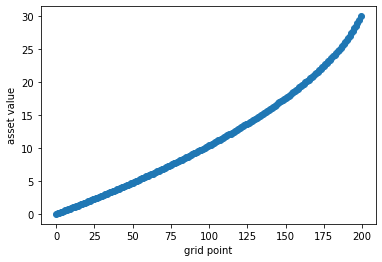

In [23]:
fig, ax = plt.subplots()
ax.scatter(range(par.Na),par.a_grid)
ax.set(xlabel='grid point',ylabel='asset value');

* for lower values of assets there are more points if spaced uneven due to the structure of nonlinspace
* for more solution points the computation times increases

## Solve the model

In [24]:
model.solve()

**Last period, $t=T-1$**

The code
```python
sol.c[t,:] = par.a_grid + par.yt[t]
sol.V[t,:] = self.util(sol.c[t,:])
```
Corresponds to the following equations
$$
\begin{align}
c^{\star}_{T-1}(a_{T-1}) &= a_{T-1}+y_{T-1}\\
V_{T-1}(a_{T-1}) &= \frac{(a_{T-1}+y_{T-1})^{1-\rho}}{1-\rho}.
\end{align}
$$

### Last Period Consumption

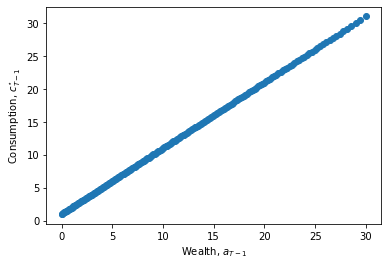

In [25]:
t = par.T-1
fig, ax = plt.subplots()
ax.scatter(par.a_grid,sol.c[t,:])
ax.set(xlabel='Wealth, $a_{T-1}$',ylabel='Consumption, $c_{T-1}^{\star}$');

**Question 1:** Why is the last period consumption function linear in wealth?

* Because last period we consume all wealth then the consumption is exactly proportional to wealth

### Last Period Value Function

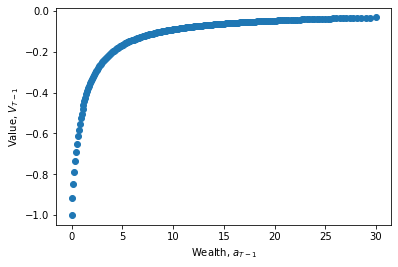

In [26]:
fig, ax = plt.subplots()
ax.scatter(par.a_grid,sol.V[t,:])
ax.set(xlabel='Wealth, $a_{T-1}$',ylabel='Value, $V_{T-1}$');

* plot last periods value as a function of state variable, wealth
* we see much more curvature in the bottom due to marginal utility of consumption being larger (CRRA type of curvature)
    - The reason for this is that a strong curvature means that the marginal utility will drop sharply if consumption increases, and will rise sharply if consumption decreases.

### Initial Period Consumption

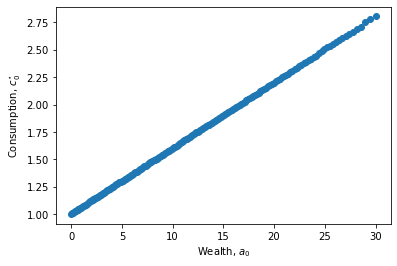

In [27]:
t = 0
fig, ax = plt.subplots()
ax.scatter(par.a_grid,sol.c[t,:])
ax.set(xlabel='Wealth, $a_{0}$',ylabel='Consumption, $c_{0}^{\star}$');

## Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by initializing all state-variables in the first period and simulate forwards. 

Initial wealth is the only state variable in our model, and we start by initiliazing all individuals with no wealth, `sim.a_init=np.zeros(par.simN)`. We then loop forward using the solution found via backward induction:
$$
\begin{align}
c_{i,t} &= c_t^{\star}(a_{i,t}) \\
a_{i,t+1} &= (1+r)(a_{i,t} + y_{i,t} - c_{i,t})
\end{align}
$$

In [28]:
model.simulate()

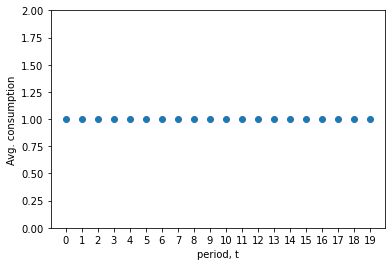

In [29]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

* plotting over individuals and they are similiar
* so here people consume income in every period in this case, if we have income 1 and zero amount of wealth at birth

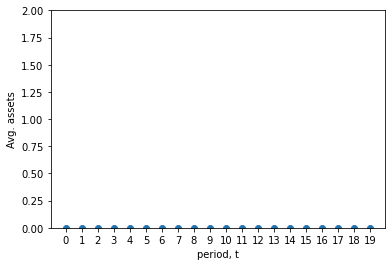

In [30]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

* Since they consume all income they have zero assets

**Question 2:** Change the value of income to $y=2$. Re-allocate, solve and simulate. Does the age profile of consumption and assets change as expected?

In [31]:
# Instantiate an object from class `ConSavModelClass`
model_y2 = model.copy()

model_y2.par.y = 2.0
# re-allocate otherwise it uses old grids (remember y is part of yt)
model_y2.allocate()

# solve model using BI
model_y2.solve()
# Then simulate forward
model_y2.simulate()

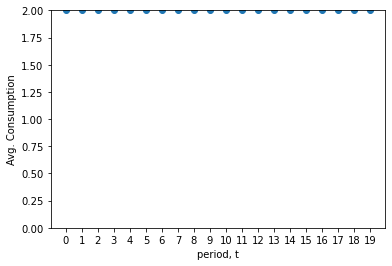

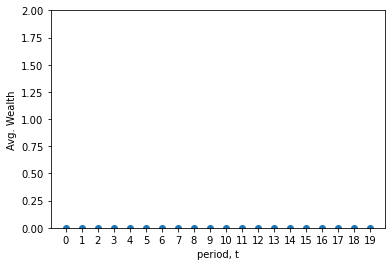

In [32]:
# Plot Consumption
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_y2.sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. Consumption',ylim=[0,2],xticks=range(par.simT));

# Plot Wealth
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_y2.sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. Wealth',ylim=[0,2],xticks=range(par.simT));

**Question 3:** Change the initial level of wealth in `sim.a_init` to be some positive number. Resimulate. Does the age profile of consumption and assets change as expected?

In [33]:
# Instantiate an object from class `ConSavModelClass`
model_y3 = model.copy()

# Assign positive initial wealth
model_y3.sim.a_init[:] = 2.0 # [:] to change all individuals wealth

# We can directly simulate model
model_y3.simulate()

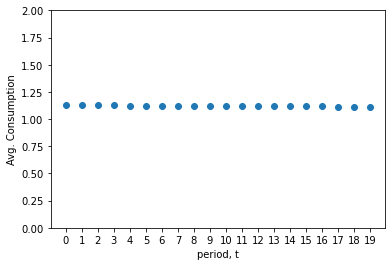

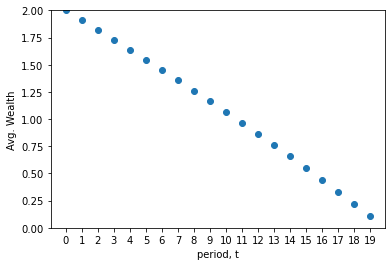

In [34]:
# Plot Consumption
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_y3.sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. Consumption',ylim=[0,2],xticks=range(par.simT));

# Plot Wealth
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_y3.sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. Wealth',ylim=[0,2],xticks=range(par.simT));

**Question 4:** Change the income process such that $y_t=0.5y$ for all periods before 10 and $y_t=y$ for all remaining periods. Try with zero initial wealth and a positive amount. Does the age profile of consumption and assets change as expected?

In [35]:
model_yt = model.copy()

model_yt.par.yt[:10] = 0.5*model_yt.par.y
model_yt.par.yt[10:] = model_yt.par.y

model_yt.solve()
model_yt.simulate()

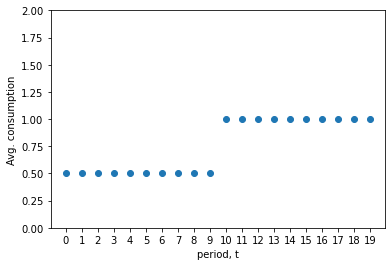

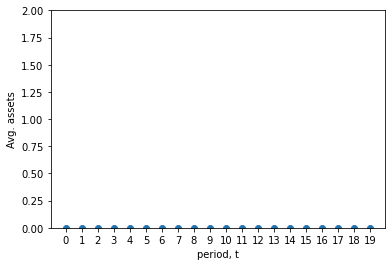

In [36]:
# Plot Consumption
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_yt.sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_yt.sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

In [37]:
# Some initial wealth
model_yt = model.copy()

model_yt.par.yt[:10] = 0.5*model_yt.par.y
model_yt.par.yt[10:] = model_yt.par.y

model_yt.solve()

# Simulate with some initial wealth
model_yt.sim.a_init[:] = 5.0
model_yt.simulate()

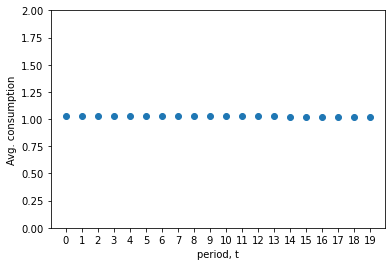

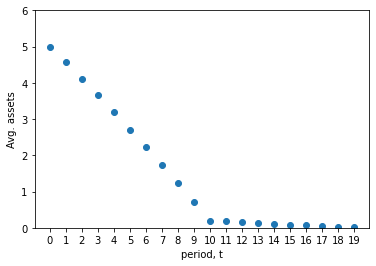

In [38]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_yt.sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(model_yt.sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,6],xticks=range(par.simT));